# How to create a cumulative PL calculation

In this notebook, we'll illustrate cumulative PL calculation. In our example, the [rate-of-return](https://www.investopedia.com/terms/r/rateofreturn.asp) will accumulate over time according to the following formulae:

$$Cumulative\ RoC = \prod_{start\_date}^{end\_date}\left ( 1+RoR \right )-1$$

This formula will recalculate automatically for every scope of data we'll add into the view

![Interactive RoR BI](interactive-ror.gif)

The example can be adjusted, for example, instead of product you can use summation over time, and the daily measure can be any profit-and-loss metric that you could think of.

\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/front-office/cumulative-pnl/main.ipynb)._]    

In [1]:
import atoti as tt

In [2]:
session = tt.Session(user_content_storage="./content")
positions = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/positions.csv",
    table_name="positions",
    keys=[
        "AsOfDate",
        "Portfolio ID",
        "Real Asset ID",
        "Instrument ID",
        "Portfolio Type",
    ],
    types={"AsOfDate": tt.type.LOCAL_DATE},
    date_patterns={"AsOfDate": "dd-MM-yyyy"},
)


positions.head()

Size  \
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type          
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active           4592   
2021-02-05 bm_02_05_0_a ra_02_05_0    CH0258404455_yhfds Benchmark        9909   
2020-01-31 a_03_05_11_a ra_03_05_11   CH0187695553_5walc Active          -4025   
2021-02-05 ra_01_02_3   ra_01_02_3    CH0238053125_l2ddb Real Asset       6488   
           a_02_05_7_b  ra_02_05_7    HK1097008929_c33f4 Active         -10870   

                                                                         Investment  \
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type               
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active               327.5   
2021-02-05 bm_02_05_0_a ra_02_05_0    CH0258404455_yhfds Benchmark           -430.8   
2020-01-31 a_03_05_11_a ra_03_05_11   CH0187695553_5walc Active               660.7   
2021-02-05 ra_01_02_3   ra_01_02_3    CH0238053125_l2ddb Real Asset          -110.3   
           a_02_05_7_b  ra_02_05_7    HK1097008929_c33f4 Active              -324.5   

                                                                         Profit-and-loss  
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type                   
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active                    2.798  
2021-02-05 bm_02_05_0_a ra_02_05_0    CH0258404455_yhfds Benchmark                -0.959  
2020-01-31 a_03_05_11_a ra_03_05_11   CH0187695553_5walc Active                   -0.925  
2021-02-05 ra_01_02_3   ra_01_02_3    CH0238053125_l2ddb Real Asset                1.926  
           a_02_05_7_b  ra_02_05_7    HK1097008929_c33f4 Active                    0.009

In [3]:
instrument_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/instrument_attributes.csv",
    table_name="instrument_attributes",
    keys=["Instrument ID"],
)


instrument_attributes.head()

,Instrument Name,Instrument Currency,Instrument Type,Issuer,Country,Coupon,Yield,Maturity Date,Issue Date
Instrument ID,,,,,,,,,
US0567521085_m2102,Baidu.com Inc.,USD,Shares,N/A,USA,NaN,NaN,N/A,N/A
CNE1000003X6_d6j6z,Ping An Insurance Co.,HKD,Shares,N/A,China,NaN,NaN,N/A,N/A
INE203G01027_hqj57,Indraprastha Gas Ltd,INR,Shares,N/A,India,NaN,NaN,N/A,N/A
KR7051910008_hsyls,Lg Chemical Ltd,KRW,Shares,N/A,South Korea,NaN,NaN,N/A,N/A
DE000LEG1110_geusb,Leg Immobilien,EUR,Shares,N/A,Germany,NaN,NaN,N/A,N/A


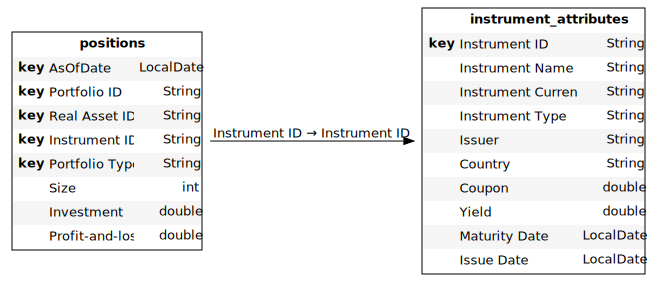

In [4]:
cube = session.create_cube(positions, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

positions.join(instrument_attributes)
cube.schema

In [5]:
m["Daily ROR"] = m["Profit-and-loss.SUM"] / m["Investment.SUM"]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

m["Daily ROR + 1"] = m["Daily ROR"] + 1
m["Daily ROR + 1"].formatter = "DOUBLE[#,##0.0000]"

In [6]:
cube.create_date_hierarchy(
    "Calendar",
    column=positions["AsOfDate"],
    levels={"Year": "Y", "Month": "MMMM", "Day": "d"},
)
h["Calendar"].slicing = True

In [7]:
cube.levels["Month"].order = tt.CustomOrder(
    first_elements=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
)

In [8]:
m["Since Inception ROR"] = (
    tt.agg.prod(
        m["Daily ROR + 1"],
        scope=tt.CumulativeScope(level=l["Day"]),
    )
    - 1
)
m["Since Inception ROR"].formatter = "DOUBLE[#,##0.000%]"

m["MtD ROR"] = tt.where(
    l["Day"] != None,
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.CumulativeScope(level=l["Day"], partitioning=l["Month"]),
        )
        - 1
    ),
)
m["MtD ROR"].formatter = "DOUBLE[#,##0.000%]"

m["YtD ROR"] = tt.where(
    l["Day"] != None,
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.CumulativeScope(level=l["Day"], partitioning=l["Year"]),
        )
        - 1
    ),
)
m["YtD ROR"].formatter = "DOUBLE[#,##0.000%]"

In [9]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.